In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras as K
import xgboost as xg

import numpy as np
from numpy import random as rand
rand.seed(2442)

2022-02-10 16:14:13.396573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 16:14:13.396628: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1) Example de feature engineering

In [2]:
n_points = 1000000
angles = pd.Series(rand.uniform(0,2*np.pi,n_points),name="angle")
true_radius = pd.Series(rand.choice(range(0,10),n_points),name="true_radius")

circle_data = pd.DataFrame(zip(angles,true_radius),columns=["angle","true_radius"])
circle_data = circle_data.assign(radius=lambda x: rand.normal(x.true_radius, 0.4))

circle_data["target"] = circle_data["true_radius"].map(lambda x: np.rint(x)%2)
circle_data["x"] = circle_data["radius"] * np.cos(circle_data["angle"])
circle_data["y"] = circle_data["radius"] * np.sin(circle_data["angle"])
circle_data["z"] = rand.uniform(0,10,n_points)

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


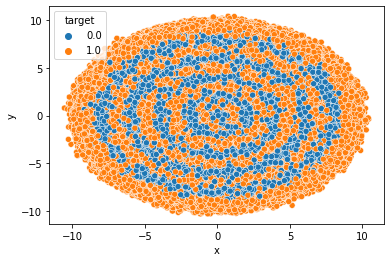

In [3]:
sns.scatterplot(x="x",y="y",data=circle_data,hue="target")
plt.show()

<AxesSubplot:xlabel='x', ylabel='reco_radius'>

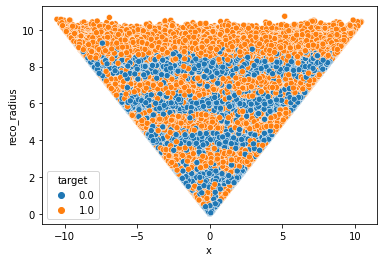

In [4]:
circle_data["reco_radius"] = np.sqrt(circle_data["x"]**2 + circle_data["y"]**2)
sns.scatterplot(data=circle_data,x="x",y="reco_radius",hue="target")

<AxesSubplot:xlabel='is_odd', ylabel='Count'>

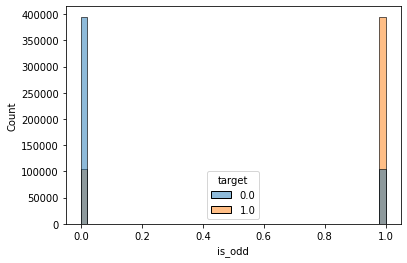

In [5]:
circle_data['is_odd'] = circle_data['reco_radius'].map(lambda x: np.rint(x)%2)
sns.histplot(data=circle_data,x="is_odd",hue="target")

In [6]:
metrics.accuracy_score(circle_data["target"],circle_data['is_odd'])

0.78894

# 2) Example over-fitting & underfitting

In [7]:
npoints=60
x = rand.normal(0,2,npoints)
y = 3*x+5*x**2-3*x**3+rand.normal(0,60,npoints)
y -= min(y)
y /= max(y)

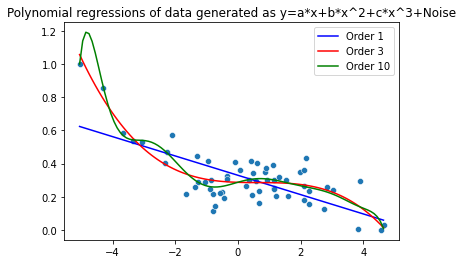

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def poly_reg(deg,x):
    poly_reg = PolynomialFeatures(degree=deg)
    X_poly = poly_reg.fit_transform(x.reshape(-1, 1))
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)
    return pol_reg,poly_reg

X_grid = np.arange(min(x), max(x), 0.1)
X_grid = X_grid.reshape(len(X_grid), 1) 

orders={
    1:'blue',
    3:'red',
    10:'green',
}

for id,val in orders.items():
    pol,poly = poly_reg(id,x)
    plt.plot(X_grid, pol.predict(poly.fit_transform(X_grid)), color=val,label=f"Order {id}")

sns.scatterplot(x=x,y=y)
plt.title("Polynomial regressions of data generated as y=a*x+b*x^2+c*x^3+Noise")
plt.show()

# 3) Example coefficient correlation

### 1 - Multivariate Gaussian

In [9]:
npoints=1000
# Moyennes :
m = np.array([-1,1,4])
# Matrice de correlation souhaitee
r = np.array(
    [
        [  1, 0.2, 0.5],
        [ 0.2,  1, 0.7],
        [ 0.5, 0.7, 1]
    ])
data_corr = pd.DataFrame(rand.multivariate_normal(m, r, size=npoints),columns=['x','y','z'])

Text(0.5, 1.0, 'Multi-variate gaussian model (2D proj)')

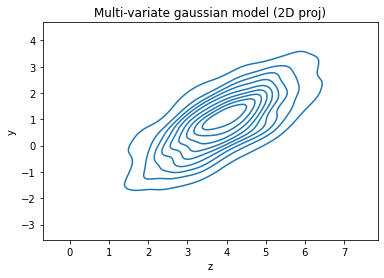

In [10]:
sns.kdeplot(x='z',y='y',data=data_corr)
plt.title("Multi-variate gaussian model (2D proj)")

Text(0.5, 1.0, 'Correlation plot for data generated according to multi-variate Gaussian')

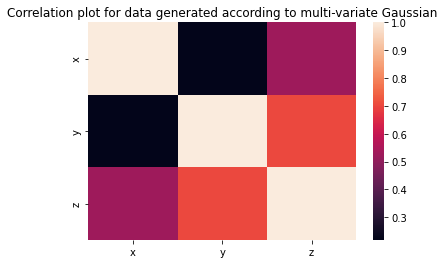

In [11]:
sns.heatmap(data_corr.corr())
plt.title("Correlation plot for data generated according to multi-variate Gaussian")

### 2 - Example where correlations doesn't show the relation & Mutual Information does

Let's take back the "circle" model we had before, and this time add an additional uniform dimension that's not linked to the target (z)

Text(0.5, 1.0, 'Correlation plot for data from the "circle" model')

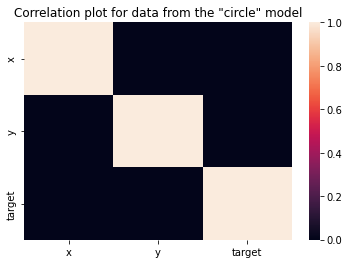

In [12]:
sns.heatmap(circle_data[["x","y","target"]].corr())
plt.title("Correlation plot for data from the \"circle\" model")

Text(0.5, 1.0, 'Mutual Information Scores for the "cylinder model" (circles model + uniform z)')

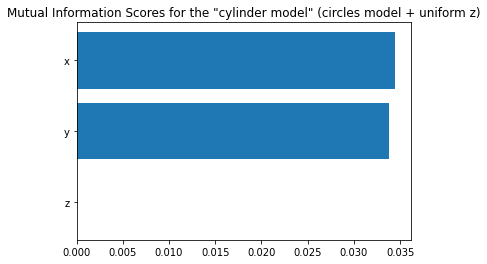

In [13]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y) #, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)

plot_mi_scores(make_mi_scores(circle_data[["x","y","z"]],circle_data["target"]))
plt.title("Mutual Information Scores for the \"cylinder model\" (circles model + uniform z)")

# 4) Example loss power in copper cable

Keep in mind : here I assess the performances on the same than the I trained on, which you should avoid !

As it was done for illustrative purposes it's more +/- fine

In [70]:
rand.seed(42)
n_cables = 75000
current_density = 0.75 #A/mm^2

data_cable = pd.DataFrame()
data_cable['radius'] = rand.normal(13, 1.3, n_cables)
data_cable['length'] = rand.normal(3000, 3000*0.15, n_cables)
data_cable['resistivity'] = rand.normal(1.7*1e-5, 0.2*1.7*1e-5, n_cables)
data_cable = data_cable.assign(
    power=lambda x: np.pi * x.resistivity * x.length * (x.radius**2) * (current_density**2)
)

<AxesSubplot:ylabel='Frequency'>

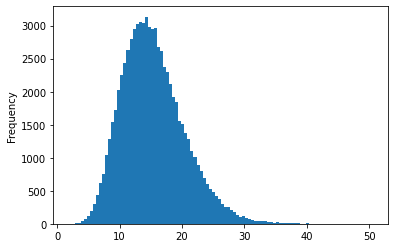

In [71]:
data_cable['power'].plot(kind='hist',bins=100)

In [72]:
model = K.Sequential(
    [
        K.layers.Dense(6, activation="relu", name="layer1"),
        K.layers.Dense(6, activation="relu", name="layer2"),
        K.layers.Dense(6, activation="relu", name="layer3"),
        K.layers.Dense(6, activation="relu", name="layer4"),
        K.layers.Dense(1, name="layer5")
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(data_cable[["radius","length","resistivity"]], data_cable[["power"]], epochs=20, batch_size=1024)

Epoch 1/20
74/74 [==============================] - 1s 2ms/step - loss: 229915.9062 - mse: 229915.9062
Epoch 2/20
74/74 [==============================] - 0s 2ms/step - loss: 10130.0352 - mse: 10130.0352
Epoch 3/20
74/74 [==============================] - 0s 2ms/step - loss: 925.0669 - mse: 925.0669
Epoch 4/20
74/74 [==============================] - 0s 2ms/step - loss: 141.4709 - mse: 141.4709
Epoch 5/20
74/74 [==============================] - 0s 2ms/step - loss: 29.5809 - mse: 29.5809
Epoch 6/20
74/74 [==============================] - 0s 2ms/step - loss: 20.0514 - mse: 20.0514
Epoch 7/20
74/74 [==============================] - 0s 2ms/step - loss: 19.5759 - mse: 19.5759
Epoch 8/20
74/74 [==============================] - 0s 2ms/step - loss: 19.5632 - mse: 19.5632
Epoch 9/20
74/74 [==============================] - 0s 2ms/step - loss: 19.5632 - mse: 19.5632
Epoch 10/20
74/74 [==============================] - 0s 3ms/step - loss: 19.5630 - mse: 19.5630
Epoch 11/20
74/74 [============

In [73]:
res=model.predict(data_cable[["radius","length","resistivity"]])
res=res[:,0]-data_cable["power"]
res /= data_cable["power"]

8.908720764954747 34.932271263742486


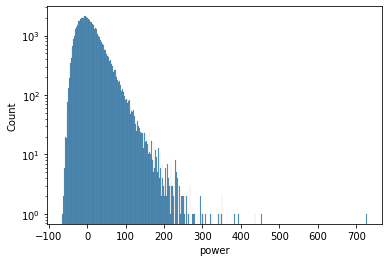

In [74]:
sns.histplot(100*res)
plt.yscale('log')
print(f"{np.mean(100*res)} {np.std(100*res)}")

In [75]:
model = K.Sequential(
    [
        K.layers.BatchNormalization(),
        K.layers.Dense(6, activation="relu", name="layer1"),
        K.layers.Dense(6, activation="relu", name="layer2"),
        K.layers.Dense(6, activation="relu", name="layer3"),
        K.layers.Dense(6, activation="relu", name="layer4"),
        K.layers.Dense(1, name="layer5")
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(data_cable[["radius","length","resistivity"]], data_cable[["power"]], epochs=20, batch_size=1024)

res2=model.predict(data_cable[["radius","length","resistivity"]])
res2=res2[:,0]-data_cable["power"]
res2 /= data_cable["power"]

Epoch 1/20
74/74 [==============================] - 1s 3ms/step - loss: 240.7502 - mse: 240.7502
Epoch 2/20
74/74 [==============================] - 0s 3ms/step - loss: 151.4266 - mse: 151.4266
Epoch 3/20
74/74 [==============================] - 0s 2ms/step - loss: 33.4379 - mse: 33.4379
Epoch 4/20
74/74 [==============================] - 0s 2ms/step - loss: 15.4369 - mse: 15.4369
Epoch 5/20
74/74 [==============================] - 0s 2ms/step - loss: 12.4447 - mse: 12.4447
Epoch 6/20
74/74 [==============================] - 0s 3ms/step - loss: 11.4747 - mse: 11.4747
Epoch 7/20
74/74 [==============================] - 0s 2ms/step - loss: 10.9888 - mse: 10.9888
Epoch 8/20
74/74 [==============================] - 0s 3ms/step - loss: 10.7205 - mse: 10.7205
Epoch 9/20
74/74 [==============================] - 0s 3ms/step - loss: 10.5599 - mse: 10.5599
Epoch 10/20
74/74 [==============================] - 0s 2ms/step - loss: 10.4648 - mse: 10.4648
Epoch 11/20
74/74 [==========================

5.333828588103528 25.169647171454788


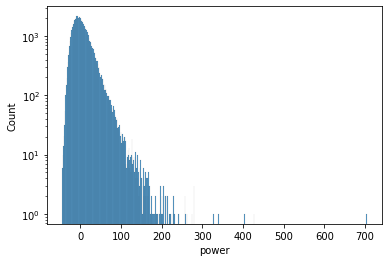

In [76]:
sns.histplot(100*res2)
plt.yscale('log')
print(f"{np.mean(100*res2)} {np.std(100*res2)}")